In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

actions = ['Deep']

start_idx_mass = []
end_idx_mass = []


In [29]:
for action in actions:
  ik_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/IK"
  ik_files = [f for f in os.listdir(ik_path) if f.endswith('.mot')]
  dfs =[pd.read_csv(os.path.join(ik_path, ik_file), sep='\t', skiprows=10, comment="#") for ik_file in ik_files]

  start_idx_all = []
  end_idx_all = []

  for index, (df, ik_file) in enumerate(zip(dfs, ik_files)):

    parts = ik_file.split("_")  
    # ['1', 'Hanif', 'Deep', '2', '5']

    trial = parts[0]
    name = parts[1]
    depth = parts[2]
    load = float(parts[3] + "." + parts[4])

    time  = df["time"].values
    angle = df["knee_angle_r"].values  # or whatever your column is called

    # 1) subtract baseline (first N frames)
    baseline   = angle[:30].mean()
    angle_rel  = angle - baseline

    # 2) choose start/end indices

    moving_idx = np.where(np.abs(angle_rel) > 5)[0]
    start_idx  = moving_idx[0]
    end_idx    = moving_idx[-1]

    start_idx_all.append(start_idx)
    end_idx_all.append(end_idx)

  start_idx_mass.append(start_idx_all)
  end_idx_mass.append(end_idx_all)

46.511840242
46.730109380799995
51.25743904799999
40.3098841983
51.236754250000025
56.50260144899993
49.1906264956
51.7417547792
63.56375673449998


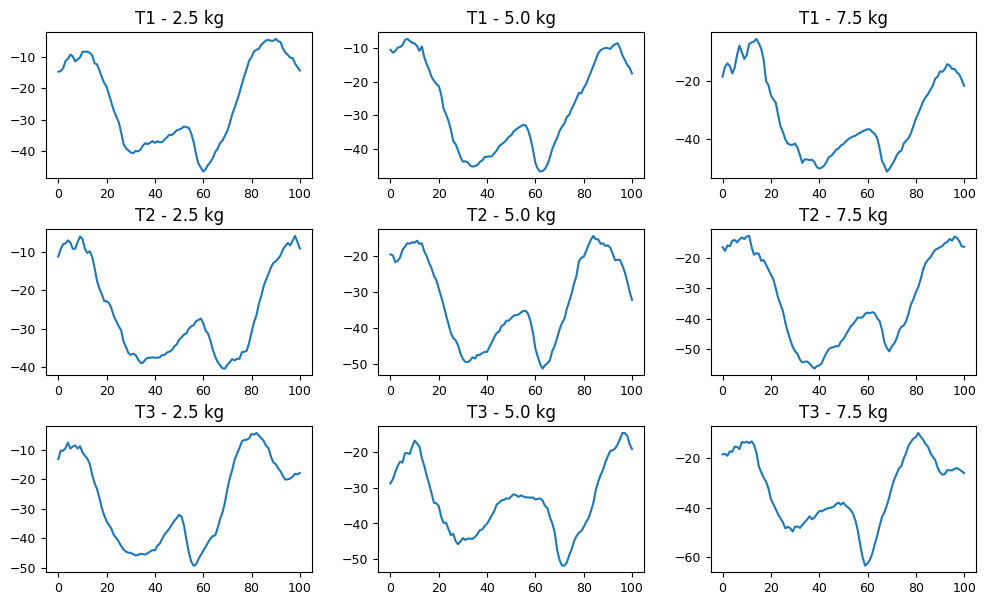

In [30]:
id_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/ID"
id_files = [f for f in os.listdir(id_path) if f.endswith('.sto')]
dfs_id =[pd.read_csv(os.path.join(id_path, id_file), sep='\t', skiprows=6) for id_file in id_files]

fig, axes = plt.subplots(3, 3, figsize=(10,6))
axes = axes.flatten()

mom_2_5_hip = []   # trial1, trial2, trial3
mom_5_0_hip = []
mom_7_5_hip = []
mom_2_5_knee = []   # trial1, trial2, trial3
mom_5_0_knee = []
mom_7_5_knee = []


for index, (df, ik_file) in enumerate(zip(dfs_id, ik_files)):

  parts = ik_file.split("_")  
  # ['1', 'Hanif', 'Deep', '2', '5']

  trial = parts[0]
  name = parts[1]
  depth = parts[2]
  load = float(parts[3] + "." + parts[4])

  time_id = df['time'].values
  hip_moment_r = df['hip_flexion_r_moment'].values
  knee_angle_r = df['knee_angle_r_moment'].values

  # --- Use your IK start_idx and end_idx from earlier ---
  start_idx = start_idx_all[index]
  end_idx = end_idx_all[index]
  t_seg_id   = time_id[start_idx:end_idx+1]
  mom_seg_hip    = hip_moment_r[start_idx:end_idx+1]
  mom_seg_knee    = knee_angle_r[start_idx:end_idx+1]


  # --- Normalize to 101 points ---
  t_target = np.linspace(t_seg_id[0], t_seg_id[-1], 101)
  mom_norm_hip = np.interp(t_target, t_seg_id, mom_seg_hip)
  mom_norm_knee = np.interp(t_target, t_seg_id, mom_seg_knee)


  # --- Extract peak moment ---
  peak_moment_hip = np.max(abs(mom_norm_hip))
  peak_moment_knee = np.max(abs(mom_norm_knee))

  # as you loop through each trial, append:
  if load == 2.5:
      mom_2_5_hip.append(mom_norm_hip)
      mom_2_5_knee.append(mom_norm_knee)
  elif load == 5.0:
      mom_5_0_hip.append(mom_norm_hip)
      mom_5_0_knee.append(mom_norm_knee)
  elif load == 7.5:
      mom_7_5_hip.append(mom_norm_hip)
      mom_7_5_knee.append(mom_norm_knee)
      
  ax = axes[index]
  ax.plot(np.linspace(0,100,101), mom_norm_hip)
  ax.set_title(f"T{trial} - {load} kg")
  ax.set_xlabel("")   # remove axis clutter
  ax.set_ylabel("")
  ax.tick_params(axis='both', which='major', labelsize=9)
  ax.tick_params(axis='both', which='major', labelsize=9)

  print(peak_moment_hip)

plt.subplots_adjust(
    left=0.05, right=0.98,
    top=0.95, bottom=0.05,
    wspace=0.25, hspace=0.35
)

plt.show()


Peak 41.18742124423334 46.042514872333335 49.92583025973334


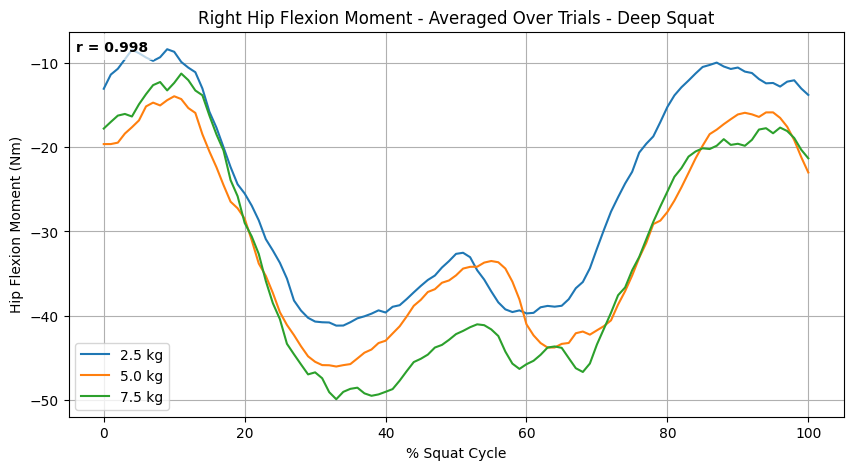

Pearson r = 0.9979451594033877
Peak 71.64470969473336 71.97554195800002 71.54723517683335


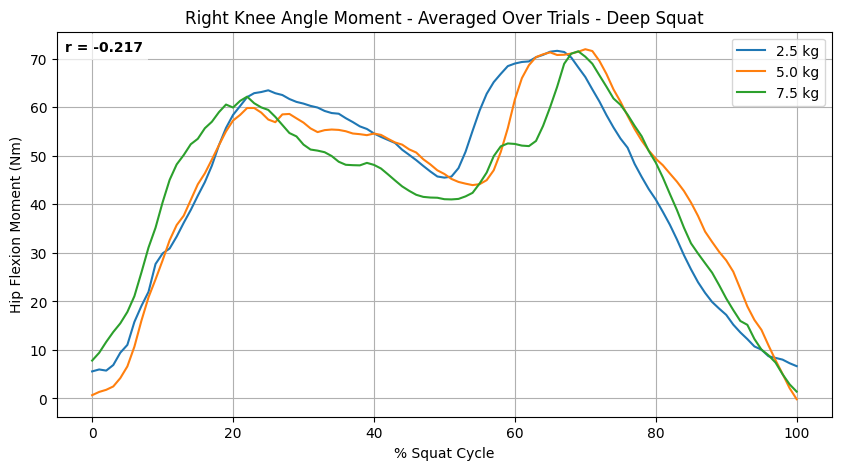

Pearson r = -0.21709373570898058


In [31]:
mean_25_hip = np.mean(np.vstack(mom_2_5_hip), axis=0)
mean_50_hip = np.mean(np.vstack(mom_5_0_hip), axis=0)
mean_75_hip = np.mean(np.vstack(mom_7_5_hip), axis=0)
x = np.linspace(0, 100, 101)

plt.figure(figsize=(10,5))
plt.plot(x, mean_25_hip, label="2.5 kg")
plt.plot(x, mean_50_hip, label="5.0 kg")
plt.plot(x, mean_75_hip, label="7.5 kg")

plt.title(f"Right Hip Flexion Moment - Averaged Over Trials - {action} Squat")
plt.xlabel("% Squat Cycle")
plt.ylabel("Hip Flexion Moment (Nm)")
plt.legend()
plt.grid(True)

peak25_hip = np.max(np.abs(mean_25_hip))
peak50_hip = np.max(np.abs(mean_50_hip))
peak75_hip = np.max(np.abs(mean_75_hip))

print(f"Peak {peak25_hip} {peak50_hip} {peak75_hip}" )

load_array = np.array([2.5, 5.0, 7.5])
peak_array = np.array([peak25_hip, peak50_hip, peak75_hip])

r = np.corrcoef(load_array, peak_array)[0,1]

plt.text(
    0.01, 0.95,
    f"r = {r:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,          # bigger
    fontweight='bold',    # bold
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()

print("Pearson r =", r) 

print("=============================")

mean_25_knee = np.mean(np.vstack(mom_2_5_knee), axis=0)
mean_50_knee = np.mean(np.vstack(mom_5_0_knee), axis=0)
mean_75_knee = np.mean(np.vstack(mom_7_5_knee), axis=0)
x = np.linspace(0, 100, 101)

plt.figure(figsize=(10,5))
plt.plot(x, mean_25_knee, label="2.5 kg")
plt.plot(x, mean_50_knee, label="5.0 kg")
plt.plot(x, mean_75_knee, label="7.5 kg")

plt.title(f"Right Knee Angle Moment - Averaged Over Trials - {action} Squat")
plt.xlabel("% Squat Cycle")
plt.ylabel("Hip Flexion Moment (Nm)")
plt.legend()
plt.grid(True)


peak25_knee = np.max(np.abs(mean_25_knee))
peak50_knee = np.max(np.abs(mean_50_knee))
peak75_knee = np.max(np.abs(mean_75_knee))

print(f"Peak {peak25_knee} {peak50_knee} {peak75_knee}" )

load_array = np.array([2.5, 5.0, 7.5])
peak_array = np.array([peak25_knee, peak50_knee, peak75_knee])

r = np.corrcoef(load_array, peak_array)[0,1]

plt.text(
    0.01, 0.95,
    f"r = {r:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,          # bigger
    fontweight='bold',    # bold
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()
print("Pearson r =", r) 

In [32]:
print(end_idx_mass)

[[370, 428, 537, 332, 440, 505, 370, 451, 553]]


In [ ]:

peak_gmax = {
    "Shallow": {"2.5": [], "5.0": [], "7.5": []},
    "Medium":  {"2.5": [], "5.0": [], "7.5": []},
    "Deep":    {"2.5": [], "5.0": [], "7.5": []}
}

peak_vas = {
    "Shallow": {"2.5": [], "5.0": [], "7.5": []},
    "Medium":  {"2.5": [], "5.0": [], "7.5": []},
    "Deep":    {"2.5": [], "5.0": [], "7.5": []}
}

for index1, action in enumerate(actions):
  start_idx_alltrial = start_idx_mass[index1]
  end_idx_alltrial = end_idx_mass[index1]
  ik_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/IK"
  ik_files = [f for f in os.listdir(ik_path) if f.endswith('.mot')]
  dfs =[pd.read_csv(os.path.join(ik_path, ik_file), sep='\t', skiprows=10, comment="#") for ik_file in ik_files]

  cmc_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/CMC"
  cmc_folders = [f for f in os.listdir(cmc_path)]

  dfs_cmc =[pd.read_csv(os.path.join(cmc_path, cmc_folder, "Hanif-Scaled_states.sto"), sep='\t', skiprows=6, comment="#") for cmc_folder in cmc_folders]

  # fig, axes = plt.subplots(3, 3, figsize=(10,6))
  # axes = axes.flatten()

  gmax_2_5 = []     # glute max activation for 2.5 kg trials (3 trials)
  gmax_5_0 = []     # for 5.0 kg
  gmax_7_5 = []     # for 7.5 kg

  vas_2_5 = []      # vastus activation for 2.5 kg
  vas_5_0 = []      # 5.0 kg
  vas_7_5 = []      # 7.5 kg


  for index2, (df, df_ik, ik_file) in enumerate(zip(dfs_cmc, dfs, ik_files)):

    parts = ik_file.split("_")  
    # ['1', 'Hanif', 'Deep', '2', '5']

    trial = parts[0]
    name = parts[1]
    depth = parts[2]
    load = float(parts[3] + "." + parts[4])
    load_str = f"{parts[3]}.{parts[4]}"  # "2.5", "5.0", "7.5"

    time_cmc  = df['time'].values
    raw_gmax = ((
      df["/forceset/glut_max1_r/activation"] +
      df["/forceset/glut_max2_r/activation"] +
      df["/forceset/glut_max3_r/activation"]
      ) / 3).values
    
    raw_vas = df["/forceset/vas_int_r/activation"].values

    ik_start_time = df_ik['time'][start_idx_alltrial[index2]]
    ik_end_time   = df_ik['time'][end_idx_alltrial[index2]]

    # --- Use your IK start_idx and end_idx from earlier ---
    mask = (time_cmc >= ik_start_time) & (time_cmc <= ik_end_time)
    t_seg_cmc = time_cmc[mask]
    gmax_seg  = raw_gmax[mask]
    vas_seg   = raw_vas[mask]

    # --- Normalize CMC segment time to 0–1 ---
    t_norm_cmc = (t_seg_cmc - t_seg_cmc[0]) / (t_seg_cmc[-1] - t_seg_cmc[0])
    # --- Target normalized timeline (0–100%) ---
    t_target = np.linspace(0, 1, 101)

    # --- Normalize to 101 points ---
    gmax_norm = np.interp(t_target, t_norm_cmc, gmax_seg)
    vas_norm  = np.interp(t_target, t_norm_cmc, vas_seg)

    # --- Extract peak moment ---
    peak_activation_gmax = np.max(abs(gmax_norm))
    peak_activation_vas = np.max(abs(vas_norm))

    # as you loop through each trial, append:
    if load == 2.5:
        gmax_2_5.append(gmax_norm)
        vas_2_5.append(vas_norm)
    elif load == 5.0:
        gmax_5_0.append(gmax_norm)
        vas_5_0.append(vas_norm)
    elif load == 7.5:
        gmax_7_5.append(gmax_norm)
        vas_7_5.append(vas_norm)
    peak_gmax[depth][load_str].append(peak_activation_gmax)
    peak_vas[depth][load_str].append(peak_activation_vas)
        
  

  
  #   ax = axes[index]
  #   ax.plot(np.linspace(0,100,101), gmax_norm)
  #   ax.set_title(f"T{trial} - {load} kg")
  #   ax.set_xlabel("")   # remove axis clutter
  #   ax.set_ylabel("")
  #   ax.tick_params(axis='both', which='major', labelsize=9)
  #   ax.tick_params(axis='both', which='major', labelsize=9)
  #   ax = axes[index]
  #   ax.plot(np.linspace(0,100,101), vas_norm)
  #   ax.set_title(f"T{trial} - {load} kg")
  #   ax.set_xlabel("")   # remove axis clutter
  #   ax.set_ylabel("")
  #   ax.tick_params(axis='both', which='major', labelsize=9)
  #   ax.tick_params(axis='both', which='major', labelsize=9)

  # plt.subplots_adjust(
  #     left=0.05, right=0.98,
  #     top=0.95, bottom=0.05,
  #     wspace=0.25, hspace=0.35
  # )

  # plt.show()

Peak 0.37565572499999994 0.40702314 0.3804541823292129


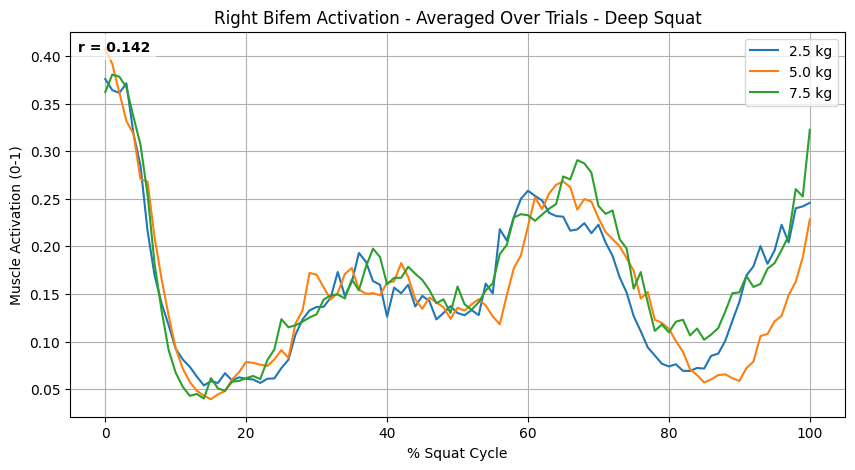

Pearson r = 0.14199978053087578
Peak 0.9013565685420112 0.7975299695263306 0.8021470395355959


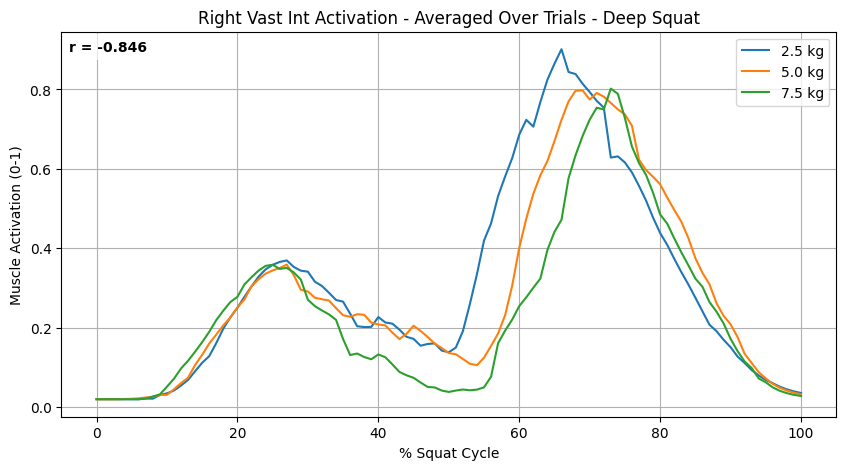

Pearson r = -0.8456761524933728


In [ ]:
mean_25_gmax = np.mean(np.vstack(gmax_2_5), axis=0)
mean_50_gmax  = np.mean(np.vstack(gmax_5_0), axis=0)
mean_75_gmax  = np.mean(np.vstack(gmax_7_5), axis=0)
x = np.linspace(0, 100, 101)

plt.figure(figsize=(10,5))
plt.plot(x, mean_25_gmax, label="2.5 kg")
plt.plot(x, mean_50_gmax, label="5.0 kg")
plt.plot(x, mean_75_gmax, label="7.5 kg")

plt.title(f"Right Glutmax Activation - Averaged Over Trials - {action} Squat")
plt.xlabel("% Squat Cycle")
plt.ylabel("Muscle Activation (0-1)")
plt.legend()
plt.grid(True)

peak25_gmax = np.max(np.abs(mean_25_gmax))
peak50_gmax = np.max(np.abs(mean_50_gmax))
peak75_gmax = np.max(np.abs(mean_75_gmax))

print(f"Peak {peak25_gmax} {peak50_gmax} {peak75_gmax}" )

load_array = np.array([2.5, 5.0, 7.5])
peak_array = np.array([peak25_gmax, peak50_gmax, peak75_gmax])

r = np.corrcoef(load_array, peak_array)[0,1]

plt.text(
    0.01, 0.95,
    f"r = {r:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,          # bigger
    fontweight='bold',    # bold
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()

print("Pearson r =", r) 

print("=============================")

mean_25_vas  = np.mean(np.vstack(vas_2_5), axis=0)
mean_50_vas  = np.mean(np.vstack(vas_5_0), axis=0)
mean_75_vas  = np.mean(np.vstack(vas_7_5), axis=0)
x = np.linspace(0, 100, 101)

plt.figure(figsize=(10,5))
plt.plot(x, mean_25_vas, label="2.5 kg")
plt.plot(x, mean_50_vas, label="5.0 kg")
plt.plot(x, mean_75_vas, label="7.5 kg")

plt.title(f"Right Vast Int Activation - Averaged Over Trials - {action} Squat")
plt.xlabel("% Squat Cycle")
plt.ylabel("Muscle Activation (0-1)")
plt.legend()
plt.grid(True)

peak25_vas = np.max(np.abs(mean_25_vas))
peak50_vas = np.max(np.abs(mean_50_vas))
peak75_vas = np.max(np.abs(mean_75_vas))

print(f"Peak {peak25_vas} {peak50_vas} {peak75_vas}" )

load_array = np.array([2.5, 5.0, 7.5])
peak_array = np.array([peak25_vas, peak50_vas, peak75_vas])

r = np.corrcoef(load_array, peak_array)[0,1]

plt.text(
    0.01, 0.95,
    f"r = {r:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,          # bigger
    fontweight='bold',    # bold
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()

print("Pearson r =", r) 

In [14]:

loads = ["2.5", "5.0", "7.5"]
depths = ["Shallow", "Medium", "Deep"]

# For Glute Max
gmax_means = np.array([
    [np.mean(peak_gmax[depth][load]) for load in loads]
    for depth in depths
])

# For Vastus
vas_means = np.array([
    [np.mean(peak_vas[depth][load]) for load in loads]
    for depth in depths
])

print(gmax_means)
print(vas_means)

[[0.29963106 0.42404878 0.45743187]
 [0.4116952  0.33460328 0.42201519]
 [0.43417411 0.40702314 0.41019978]]
[[0.71946998 0.68562482 0.70873997]
 [0.77056857 0.8807849  0.87780083]
 [0.99160645 0.97486398 0.9123741 ]]


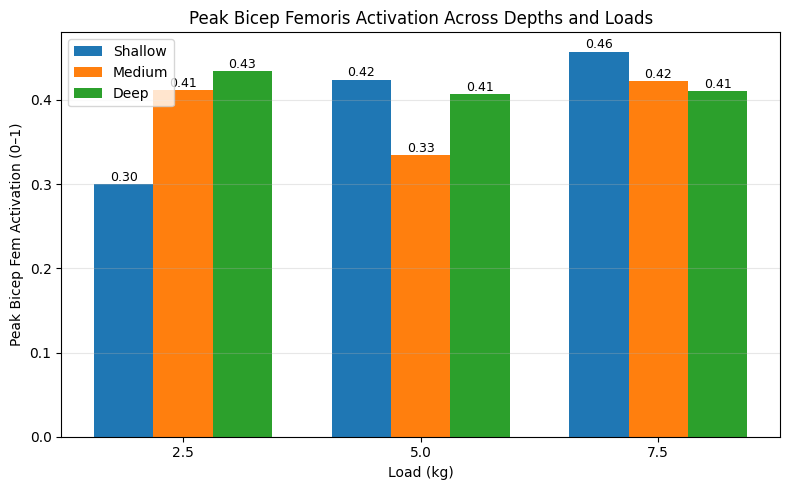

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(loads))        # [0,1,2]
width = 0.25                     # bar width

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width, gmax_means[0], width, label='Shallow')
ax.bar(x,         gmax_means[1], width, label='Medium')
ax.bar(x + width, gmax_means[2], width, label='Deep')

ax.set_xticks(x)
ax.set_xticklabels(loads)
ax.set_ylabel("Peak Bicep Fem Activation (0–1)")
ax.set_xlabel("Load (kg)")
ax.set_title("Peak Bicep Femoris Activation Across Depths and Loads")
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, depth_data in enumerate(gmax_means):
    for j, val in enumerate(depth_data):
        
        # Match the bar x-position used in bar() calls
        x_pos = j + (i - 1) * width
        
        ax.text(
            x_pos,
            val + 0.0005,      # 0.02 offset (NOT 0.2)
            f"{val:.2f}",
            ha='center', va='bottom', fontsize=9
        )

plt.tight_layout()
plt.show()

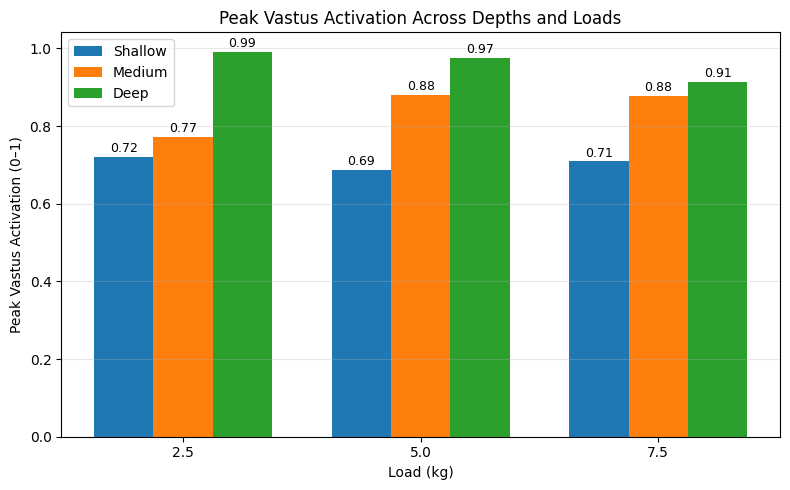

In [16]:
fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width, vas_means[0], width, label='Shallow')
ax.bar(x,         vas_means[1], width, label='Medium')
ax.bar(x + width, vas_means[2], width, label='Deep')

ax.set_xticks(x)
ax.set_xticklabels(loads)
ax.set_ylabel("Peak Vastus Activation (0–1)")
ax.set_xlabel("Load (kg)")
ax.set_title("Peak Vastus Activation Across Depths and Loads")
ax.legend()
ax.grid(axis='y', alpha=0.3)


for i, depth_data in enumerate(vas_means):
    for j, val in enumerate(depth_data):
        
        # Match the bar x-position used in bar() calls
        x_pos = j + (i - 1) * width
        
        ax.text(
            x_pos,
            val + 0.005,      # 0.02 offset (NOT 0.2)
            f"{val:.2f}",
            ha='center', va='bottom', fontsize=9
        )

plt.tight_layout()
plt.show()

In [11]:
for i, depth_data in enumerate(gmax_means):
    for j, val in enumerate(depth_data):
        ax.text(j + (i-1)*width, val + 0.01, f"{val:.2f}",
                ha='center', va='bottom', fontsize=8)